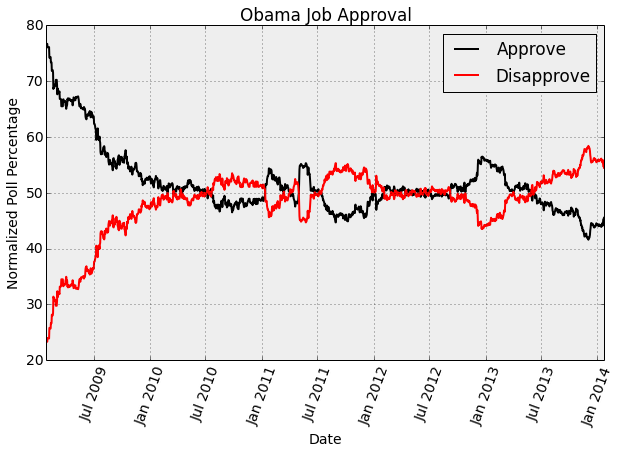

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from fnmatch import fnmatch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pattern import web
import re

import requests
import StringIO
import zipfile
import scipy.stats 

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def getPollXML(pollId = 1171):
    #the default poll Id retrieves the data for the Obama-Romney race
    address = "http://charts.realclearpolitics.com/charts/%d.xml" % pollId
    return requests.get(address).text

def _strip(s):
    """This function removes non-letter characters from a word
    for example _strip('Hi there!') == 'Hi there'
    """
    return re.sub(r'[\W_]+', '', s)

def plot_colors(xml):
    """
    Given an XML document like the link above, returns a python dictionary
    that maps a graph title to a graph color.
    
    Both the title and color are parsed from attributes of the <graph> tag:
    <graph title="the title", color="#ff0000"> -> {'the title': '#ff0000'}
    
    These colors are in "hex string" format. This page explains them:
    http://coding.smashingmagazine.com/2012/10/04/the-code-side-of-color/
    
    Example
    -------
    >>> plot_colors(get_poll_xml(1044))
    {u'Approve': u'#000000', u'Disapprove': u'#FF0000'}
    """
    dom = web.Element(xml)
    result = {}
    for graph in dom.by_tag('graph'):
        title = _strip(graph.attributes['title'])
        result[title] = graph.attributes['color']
    return result

def rcpPollData(inputXMLData):
    dom = web.Element(inputXMLData)
    result = {}
    
    dates = dom.by_tag('series')[0]    
    dates = {n.attributes['xid']: str(n.content) for n in dates.by_tag('value')}
    
    keys = dates.keys()
    
    result['date'] = pd.to_datetime([dates[k] for k in keys])
    
    for graph in dom.by_tag('graph'):
        name = graph.attributes['title']
        data = {n.attributes['xid']: float(n.content) 
                if n.content else np.nan for n in graph.by_tag('value')}
        result[name] = [data[k] for k in keys]
        
    result = pd.DataFrame(result)    
    result = result.sort(columns=['date'])
        
    return result

def poll_plot(poll_id):
    """
    Make a plot of an RCP Poll over time
    
    Parameters
    ----------
    poll_id : int
        An RCP poll identifier
    """

    # hey, you wrote two of these functions. Thanks for that!
    xml = getPollXML(poll_id)
    data = rcpPollData(xml)
    colors = plot_colors(xml)

    #remove characters like apostrophes
    data = data.rename(columns = {c: _strip(c) for c in data.columns})

    #normalize poll numbers so they add to 100%    
    norm = data[colors.keys()].sum(axis=1) / 100    
    for c in colors.keys():
        data[c] /= norm
    
    for label, color in colors.items():
        plt.plot(data.date, data[label], color=color, label=label)        
        
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage")
    
poll_plot(1044)
plt.title("Obama Job Approval")

    
    

In [3]:
def getZIP(zipFileName):
    r = requests.get(zipFileName).content
    s = StringIO.StringIO(r)
    zf = zipfile.ZipFile(s, 'r') # Read in a list of zipped files
    return zf



In [4]:
url = 'http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip'
zf = getZIP(url)

tablenames = zf.namelist()
salaries = pd.read_csv(zf.open(tablenames[tablenames.index('Salaries.csv')]))
print "Number of rows: %i" % salaries.shape[0]
salaries.head()

Number of rows: 23956


,yearID,teamID,lgID,playerID,salary
0,1985,BAL,AL,murraed02,1472819
1,1985,BAL,AL,lynnfr01,1090000
2,1985,BAL,AL,ripkeca01,800000
3,1985,BAL,AL,lacyle01,725000
4,1985,BAL,AL,flanami01,641667


In [5]:
teams = pd.read_csv(zf.open(tablenames[tablenames.index('Teams.csv')]))
teams = teams[['yearID', 'teamID', 'W']]
print "Number of rows: %i" % teams.shape[0]
teams.head()

Number of rows: 2745


,yearID,teamID,W
0,1871,PH1,21
1,1871,CH1,19
2,1871,BS1,20
3,1871,WS3,15
4,1871,NY2,16


In [6]:
totSalaries = salaries.groupby(['yearID','teamID'], as_index=False).sum()
totSalaries.head()

,yearID,teamID,salary
0,1985,ATL,14807000
1,1985,BAL,11560712
2,1985,BOS,10897560
3,1985,CAL,14427894
4,1985,CHA,9846178


In [7]:
joined = pd.merge(totSalaries, teams, how="inner", on=['yearID', 'teamID'])
joined.head()

,yearID,teamID,salary,W
0,1985,ATL,14807000,66
1,1985,BAL,11560712,83
2,1985,BOS,10897560,81
3,1985,CAL,14427894,90
4,1985,CHA,9846178,85


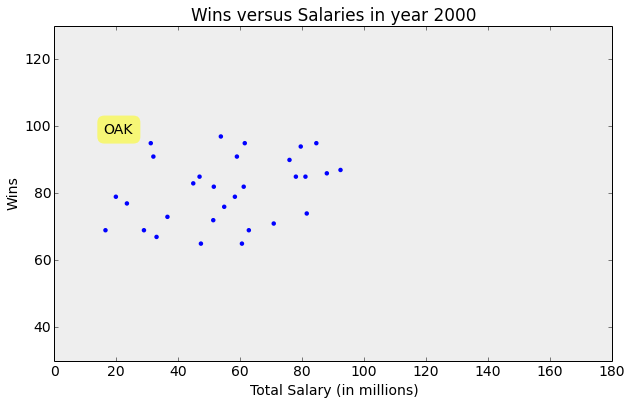

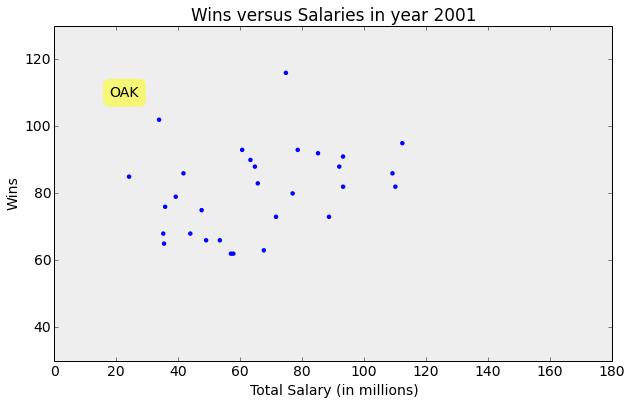

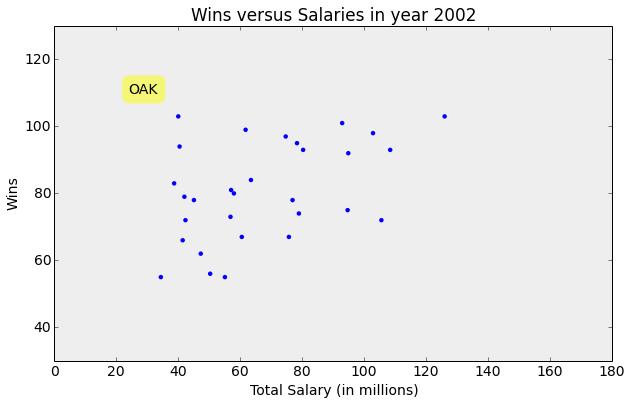

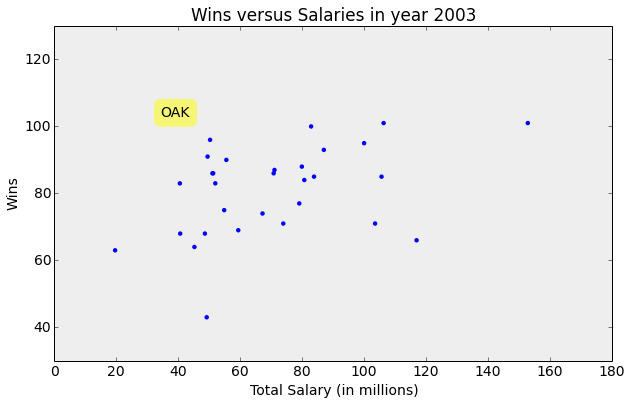

In [8]:
teamName = 'OAK'
years = np.arange(2000, 2004)

for yr in years: 
    df = joined[joined['yearID'] == yr]
    plt.scatter(df['salary'] / 1e6, df['W'])
    plt.title('Wins versus Salaries in year ' + str(yr))
    plt.xlabel('Total Salary (in millions)')
    plt.ylabel('Wins')
    plt.xlim(0, 180)
    plt.ylim(30, 130)
    plt.grid()
    plt.annotate(teamName, 
        xy = (df['salary'][df['teamID'] == teamName] / 1e6,  df['W'][df['teamID'] == teamName]), 
        xytext = (-20, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', facecolor = 'black' , connectionstyle = 'arc3,rad=0'))
    
    plt.show()

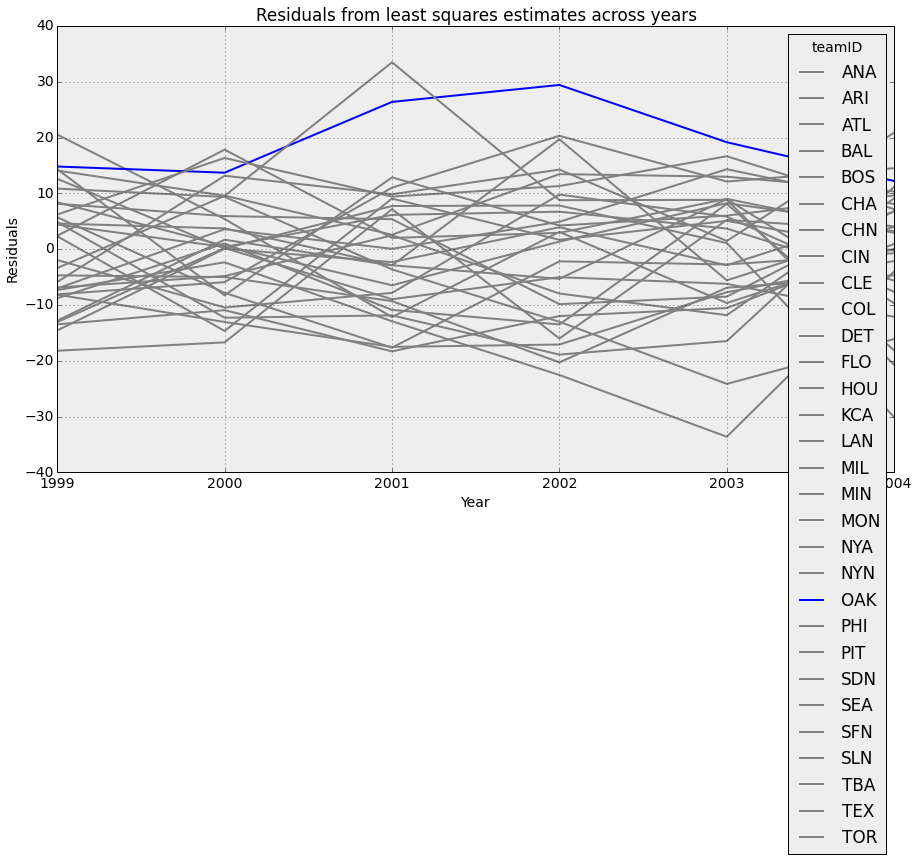

In [9]:
teamName = 'OAK'
years = np.arange(1999, 2005)
residData = pd.DataFrame()

for yr in years: 
    df = joined[joined['yearID'] == yr]
    x_list = df['salary'].values / 1e6
    y_list = df['W'].values

    # least squares estimates
    A = np.array([x_list, np.ones(len(x_list))])
    y = y_list
    w = np.linalg.lstsq(A.T,y)[0] # coefficients
    yhat = (w[0]*x_list+w[1]) # regression line
    residData[yr] = y - yhat
  
residData.index = df['teamID']
residData = residData.T
residData.index = residData.index.format()

residData.plot(title = 'Residuals from least squares estimates across years', figsize = (15, 8),
               color=map(lambda x: 'blue' if x=='OAK' else 'gray',df.teamID))
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.show()